In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
# ---------- Load and Clean ----------
def load_and_clean(path):
    df = pd.read_csv(path)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df.dropna()

# Load datasets
benign = pd.concat([
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign.csv"),
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign1.csv"),
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign2.csv"),
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign3.csv")
], ignore_index=True)

# Attack datasets
sqlInj = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/SqlInjection.csv")
uploading = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Uploading_Attack.csv")
portscan = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Recon-PortScan.csv")
Backdoor_Malware = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Backdoor_Malware.csv")
BrowserHijacking = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/BrowserHijacking.csv")
DDoS_SlowLoris = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/DDoS-SlowLoris.csv")
DNS_Spoofing = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/DNS_Spoofing.csv")
Recon_OSScan = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Recon-OSScan.csv")
VulnerabilityScan = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/VulnerabilityScan.csv")
XSS = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/XSS.csv")




In [10]:
# ---------- Feature Alignment ----------
common_cols = list(set(benign.columns) & set(uploading.columns) & set(sqlInj.columns) & set(portscan.columns) &  
                    set(Backdoor_Malware.columns) & set(BrowserHijacking.columns) & set(DDoS_SlowLoris.columns) &  
                    set(Recon_OSScan.columns) & set(VulnerabilityScan.columns) & set(XSS.columns))
if "Label" in common_cols:
    common_cols.remove("Label")

# Get only aligned features
X_benign = benign[common_cols]
X_upload = uploading[common_cols]
X_sqlInj = sqlInj[common_cols]
X_portscan = portscan[common_cols]
X_Backdoor_Malware = Backdoor_Malware[common_cols]
X_BrowserHijacking = BrowserHijacking[common_cols]
X_DDoS_SlowLoris = DDoS_SlowLoris[common_cols]
X_DNS_Spoofing = DNS_Spoofing[common_cols]
X_Recon_OSScan = Recon_OSScan[common_cols] 
X_VulnerabilityScan = VulnerabilityScan[common_cols].clip(-1e10, 1e10).replace([np.inf, -np.inf], np.nan).dropna()
X_XSS = XSS[common_cols]

In [11]:

# ---------- Scaling ----------
scaler = StandardScaler()
X_all = np.vstack([
    X_benign, X_upload, X_sqlInj, X_portscan,
    X_Backdoor_Malware, X_BrowserHijacking, X_DDoS_SlowLoris,
    X_DNS_Spoofing, X_Recon_OSScan, X_VulnerabilityScan, X_XSS
])
X_all_scaled = scaler.fit_transform(X_all)


In [12]:
# ---------- Label Construction ----------
y_all = np.array(
    [0] * len(X_benign) +
    [1] * len(X_upload) +
    [2] * len(X_sqlInj) +
    [3] * len(X_portscan) +
    [4] * len(X_Backdoor_Malware) +
    [5] * len(X_BrowserHijacking) +
    [6] * len(X_DDoS_SlowLoris) +
    [7] * len(X_DNS_Spoofing) +
    [8] * len(X_Recon_OSScan) +
    [9] * len(X_VulnerabilityScan) +
    [10] * len(X_XSS)
)


In [13]:
import numpy as np

print("Any NaNs?:", np.isnan(X_all_scaled).any())
print("Total NaNs:", np.isnan(X_all_scaled).sum())

Any NaNs?: False
Total NaNs: 0


In [14]:
# Split and balance data (Assumes X_all_scaled and y_all are ready)
X_train, X_test, y_train, y_test = train_test_split(X_all_scaled, y_all, test_size=0.2, random_state=42, stratify=y_all)

In [15]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.utils.class_weight import compute_class_weight


from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Tensors
X_res_tensor = torch.tensor(X_resampled, dtype=torch.float32).unsqueeze(1)
y_res_tensor = torch.tensor(y_resampled, dtype=torch.long)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')

dataset = TensorDataset(X_res_tensor, y_res_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [16]:
# ---------- SE Block ----------
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        weights = self.fc(x)
        return x * weights.unsqueeze(-1)

# ---------- Lightweight CNN + SE Attention ----------
class CNNSEAttention(nn.Module):
    def __init__(self, input_features, num_classes, dropout_rate=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            SEBlock(32),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            SEBlock(64),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        return self.classifier(x)

In [17]:
# ---------- Model Setup ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNSEAttention(input_features=X_res_tensor.shape[2], num_classes=len(np.unique(y_resampled))).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# ---------- Training Loop ----------
train_losses, val_f1_scores, val_accuracies = [], [], []
best_f1, best_model_path = 0.0, "best_cnn_se_attention.pth"
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
early_stop_patience, early_stop_counter = 5, 0

for epoch in range(1, 21):
    model.train()
    total_loss = 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(dataloader))

    # ---------- Validation ----------
    model.eval()
    val_logits = []
    with torch.no_grad():
        val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32))
        val_loader = DataLoader(val_dataset, batch_size=512)
        for batch in val_loader:
            xb = batch[0].unsqueeze(1).to(device)
            out = model(xb)
            val_logits.append(out.cpu())

    val_logits = torch.cat(val_logits, dim=0)
    val_preds = torch.argmax(val_logits, dim=1).numpy()
    val_f1 = f1_score(y_test, val_preds, average='weighted')
    val_acc = accuracy_score(y_test, val_preds)
    val_f1_scores.append(val_f1)
    val_accuracies.append(val_acc)

    scheduler.step(val_f1)
    print(f"Epoch {epoch}, Loss: {train_losses[-1]:.4f}, F1: {val_f1:.4f}, Acc: {val_acc:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch} with F1: {val_f1:.4f}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break


Epoch 1, Loss: 1.5509, F1: 0.6008, Acc: 0.5131
Saved best model at epoch 1 with F1: 0.6008
Epoch 2, Loss: 1.4373, F1: 0.6414, Acc: 0.5653
Saved best model at epoch 2 with F1: 0.6414
Epoch 3, Loss: 1.4068, F1: 0.6475, Acc: 0.5766
Saved best model at epoch 3 with F1: 0.6475
Epoch 4, Loss: 1.3906, F1: 0.6482, Acc: 0.5832
Saved best model at epoch 4 with F1: 0.6482
Epoch 5, Loss: 1.3798, F1: 0.6424, Acc: 0.5694
Epoch 6, Loss: 1.3732, F1: 0.6366, Acc: 0.5639
Epoch 7, Loss: 1.3646, F1: 0.6472, Acc: 0.5810
Epoch 8, Loss: 1.3586, F1: 0.6462, Acc: 0.5779
Epoch 9, Loss: 1.3406, F1: 0.6422, Acc: 0.5701
Early stopping triggered.



🔍 Evaluation of Best Saved Model:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74    219625
           1       0.01      0.33      0.02       250
           2       0.01      0.20      0.02      1049
           3       0.41      0.37      0.39     16457
           4       0.01      0.22      0.02       644
           5       0.03      0.49      0.05      1172
           6       1.00      1.00      1.00      4685
           7       0.82      0.73      0.77     35779
           8       0.15      0.08      0.10     19651
           9       0.50      0.54      0.52     74669
          10       0.01      0.32      0.02       769

    accuracy                           0.58    374750
   macro avg       0.35      0.45      0.33    374750
weighted avg       0.75      0.58      0.65    374750



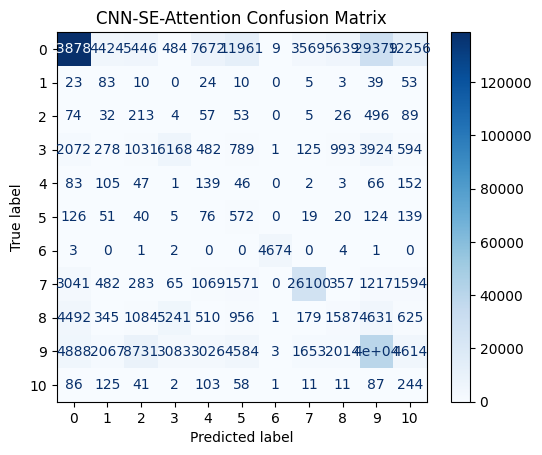

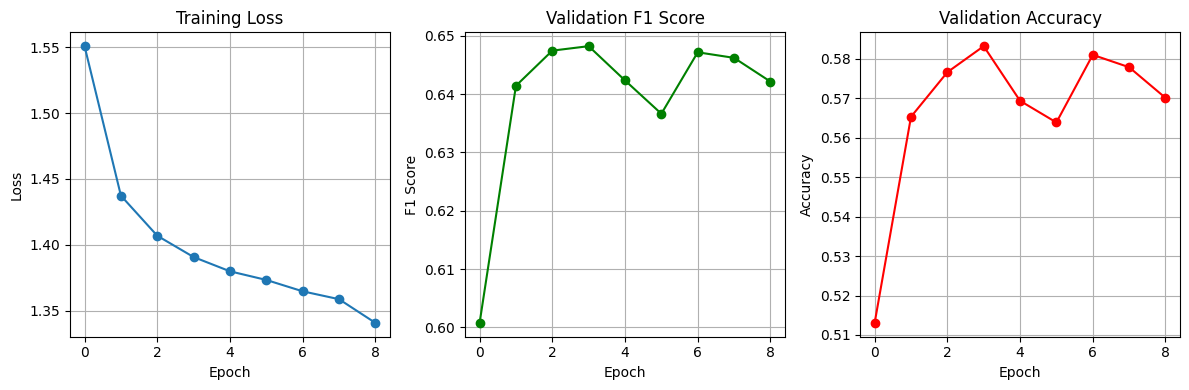

TorchScript model saved for edge deployment.


In [18]:
# ---------- Evaluation ----------
model.load_state_dict(torch.load(best_model_path))
model.eval()
eval_logits = []
with torch.no_grad():
    X_eval_tensor = torch.tensor(X_test, dtype=torch.float32)
    eval_loader = DataLoader(TensorDataset(X_eval_tensor), batch_size=512)
    for batch in eval_loader:
        xb = batch[0].unsqueeze(1).to(device)
        out = model(xb)
        eval_logits.append(out.cpu())
eval_logits = torch.cat(eval_logits, dim=0)
eval_preds = torch.argmax(eval_logits, dim=1).numpy()

print("\n🔍 Evaluation of Best Saved Model:")
print(classification_report(y_test, eval_preds))
cm = confusion_matrix(y_test, eval_preds)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("CNN-SE-Attention Confusion Matrix")
plt.grid(False)
plt.show()

# ---------- Metrics Plot ----------
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_f1_scores, marker='o', color='green')
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(val_accuracies, marker='o', color='red')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# ---------- Export for Edge Inference ----------
example_input = torch.randn(1, 1, X_res_tensor.shape[2]).to(device)
torch.jit.trace(model, example_input).save("cnn_se_attention_traced.pt")
print("TorchScript model saved for edge deployment.")

In [19]:
from sklearn.metrics import classification_report
print("🔍 Classification Report (with SMOTE):")
print(classification_report(y_test, eval_preds))


🔍 Classification Report (with SMOTE):
              precision    recall  f1-score   support

           0       0.90      0.63      0.74    219625
           1       0.01      0.33      0.02       250
           2       0.01      0.20      0.02      1049
           3       0.41      0.37      0.39     16457
           4       0.01      0.22      0.02       644
           5       0.03      0.49      0.05      1172
           6       1.00      1.00      1.00      4685
           7       0.82      0.73      0.77     35779
           8       0.15      0.08      0.10     19651
           9       0.50      0.54      0.52     74669
          10       0.01      0.32      0.02       769

    accuracy                           0.58    374750
   macro avg       0.35      0.45      0.33    374750
weighted avg       0.75      0.58      0.65    374750



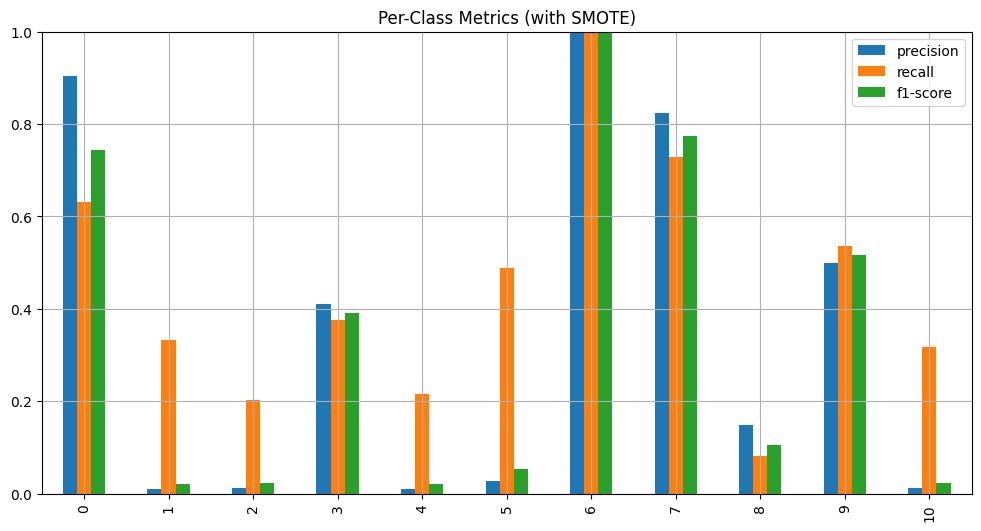

In [20]:
import pandas as pd
report = classification_report(y_test, eval_preds, output_dict=True)
df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12,6), title="Per-Class Metrics (with SMOTE)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


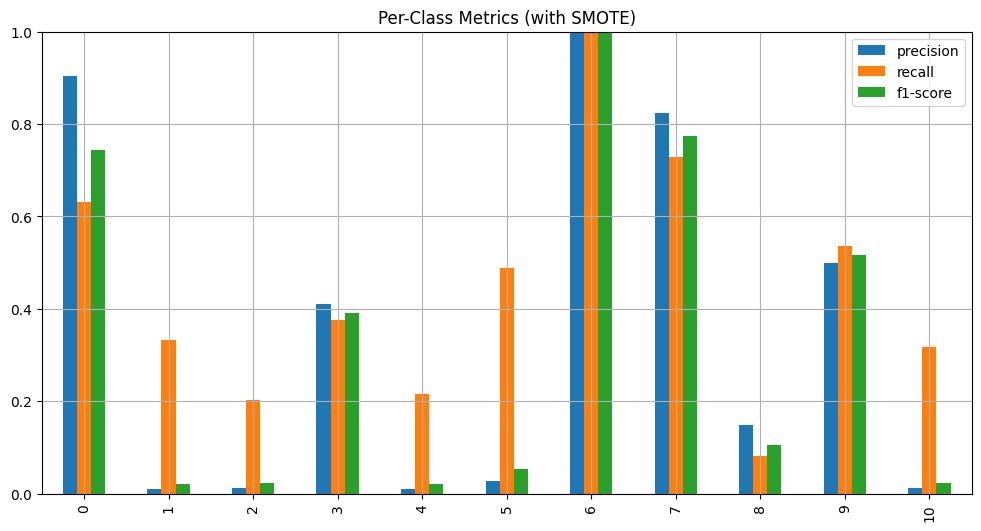

In [21]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(y_test, eval_preds, output_dict=True)
df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12,6), title="Per-Class Metrics (with SMOTE)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()